In [1]:
import pandas as pd
import numpy as np
from time import process_time
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from data_preprocessing import *
from model import *

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, LSTM, Bidirectional, Conv1D, Dropout, SpatialDropout2D, concatenate
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D, Attention
from tensorflow.keras.utils import plot_model


print(tf.__version__)

2.2.0


In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [4]:
x_train = training_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [5]:
y_train, y_val = label_encoder(y_train, y_val)

In [6]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [7]:
pad_len=100
padding_type='post'
truncating_type='post'

In [8]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(x_train, x_val)

In [9]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [ ]:
dump(tokenizer, "../tokenizers/DL-raw-tokenizer-100.pk1")

In [10]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [11]:
vocab = tokenizer.word_index

# Domain Specific Fasttext Embeddings

In [12]:
start = process_time()
embedding_path1 = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.raw.ft.skipgram.d300.vec"
embedding_matrix1 = get_embedding_matrix(embedding_path1, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix1.shape

51245
Total time taken:  4.829873731999998


(52576, 300)

In [13]:
input_dim1 = embedding_matrix1.shape[0]
embedding_dim1 = 300
input_len = pad_len
print("Input dimension 1: ", input_dim1)
print("Embedding dimensions 1: ", embedding_dim1)
print("Input sentence dimensions 1: ", input_len)

Input dimension 1:  52576
Embedding dimensions 1:  300
Input sentence dimensions 1:  100


In [20]:
inputs = Input(shape=(input_len,))
embedding_layer = Embedding(input_dim=input_dim1, 
                            output_dim=embedding_dim1, 
                            weights=[embedding_matrix1],
                            trainable=False)(inputs)

LSTM1 = Bidirectional(LSTM(64, dropout=0.3, return_sequences=True))(embedding_layer)
Dropout1 = Dropout(0.3)(LSTM1)
maxpooling_lstm = MaxPooling1D(pool_size=4)(Dropout1)
flatten_lstm = Flatten()(maxpooling_lstm)

conv1 = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(embedding_layer)
Dropout2 = Dropout(0.3)(conv1)
maxpooling_conv = MaxPooling1D(pool_size=4)(Dropout2)
flatten_conv = Flatten()(maxpooling_conv)

attention = Attention()([flatten_lstm, flatten_conv])
Dense1 = Dense(512, activation='relu')(attention)
outputs = Dense(4, activation='softmax')(Dense1)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 300)     15772800    input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 100, 128)     186880      embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 128)     192128      embedding_5[0][0]                
____________________________________________________________________________________________

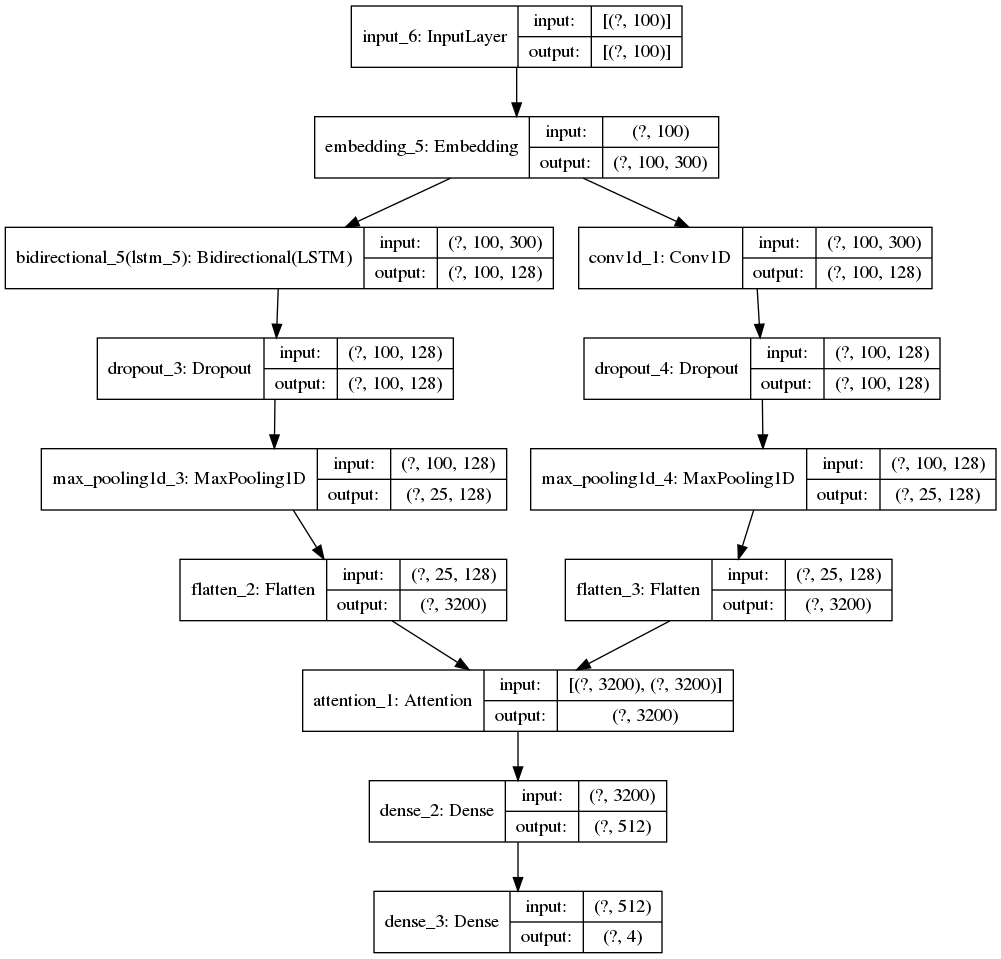

In [21]:
plot_model(model, show_shapes=True, to_file='multichannel.png')

In [22]:
history = model.fit(x_train_padded, 
                         y_train, 
                         epochs=8,
                         batch_size=128,
                         verbose=1,
                         validation_data=(x_val_padded, y_val))

Epoch 1/8
329/329 [==============================] - 142s 433ms/step - loss: 0.9854 - acc: 0.5918 - val_loss: 0.7909 - val_acc: 0.7029
Epoch 2/8
329/329 [==============================] - 149s 453ms/step - loss: 0.5602 - acc: 0.8015 - val_loss: 0.5984 - val_acc: 0.8082
Epoch 3/8
329/329 [==============================] - 155s 471ms/step - loss: 0.4744 - acc: 0.8358 - val_loss: 0.5976 - val_acc: 0.8183
Epoch 4/8
329/329 [==============================] - 200s 609ms/step - loss: 0.4452 - acc: 0.8451 - val_loss: 0.5073 - val_acc: 0.8429
Epoch 5/8
329/329 [==============================] - 243s 740ms/step - loss: 0.4112 - acc: 0.8574 - val_loss: 0.5096 - val_acc: 0.8373
Epoch 6/8
329/329 [==============================] - 262s 798ms/step - loss: 0.3912 - acc: 0.8640 - val_loss: 0.4519 - val_acc: 0.8574
Epoch 7/8
329/329 [==============================] - 231s 703ms/step - loss: 0.3697 - acc: 0.8714 - val_loss: 0.4583 - val_acc: 0.8616
Epoch 8/8
329/329 [==============================] - 17

In [ ]:
history = model.fit(x_train_padded, 
                         y_train, 
                         epochs=8,
                         batch_size=128,
                         verbose=1,
                         validation_data=(x_val_padded, y_val))

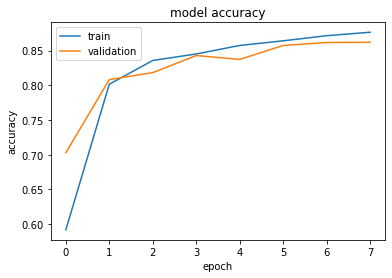

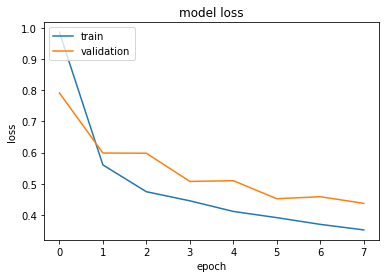

In [23]:
plot_curves(history)

In [25]:
results1 = np.argmax(model.predict(x_val_padded), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results1)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.834920634920635

Precision:  [0.6366843  0.8736631  0.84494382 0.88996372]
Average Precision:  0.8113137373711707

Recall:  [0.85952381 0.86843854 0.84971751 0.75876289]
Average Recall:  0.8341106871130054

F1-Score:  [0.73150963 0.87104299 0.84732394 0.81914302]
Average F1-Score:  0.8172548926495172


# Indic-Fasttext Embeddings

In [28]:
start = process_time()
embedding_path2 = "/home/eastwind/word-embeddings/fasttext/indicnlp.ft.mr.300.vec"
embedding_matrix2 = get_embedding_matrix(embedding_path2, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix2.shape

29684
Total time taken:  8.321486321000002


(52576, 300)

In [29]:
input_dim2 = embedding_matrix2.shape[0]
embedding_dim2 = 300
input_len = pad_len
print("Input dimension 2: ", input_dim2)
print("Embedding dimensions 2: ", embedding_dim2)
print("Input sentence dimensions 2: ", input_len)

Input dimension 2:  52576
Embedding dimensions 2:  300
Input sentence dimensions 2:  100


# Domain Specific + Indic-Fasttext Multi-channel CNN Architecture

In [64]:
# Input 1(Domain Specific Fasttext Embeddings):
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim1, output_dim=embedding_dim1, weights=[embedding_matrix1], trainable=False)(Input1)
Conv1 = Conv1D(filters=128, kernel_size=5, activation='relu')(Embedding_layer1)
MaxPooling1 = MaxPooling1D(pool_size=3)(Conv1)
Dropout1 = Dropout(0.2)(MaxPooling1)
Flatten1 = Flatten()(Dropout1)

# Input 2 (Indic-Fasttext Embeddings):
Input2 = Input(shape=(input_len,))
Embedding_layer2 = Embedding(input_dim=input_dim2, output_dim=embedding_dim2, weights=[embedding_matrix2], trainable=False)(Input2)
Conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(Embedding_layer2)
MaxPooling2 = MaxPooling1D(pool_size=3)(Conv2)
Dropout2 = Dropout(0.2)(MaxPooling2)
Flatten2 = Flatten()(Dropout2)

Merged = concatenate([Flatten1, Flatten2])
Dense1 = Dense(512, activation='relu')(Merged)
Dropout3 = Dropout(0.3)(Dense1)
Dense2 = Dense(32, activation='relu', kernel_regularizer=l2(0.015))(Dropout3)
output = Dense(4, activation='softmax')(Dense2)

classifier = Model(inputs=[Input1, Input2], outputs=output)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
classifier.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 100, 300)     15772800    input_32[0][0]                   
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 100, 300)     15772800    input_33[0][0]                   
___________________________________________________________________________________________

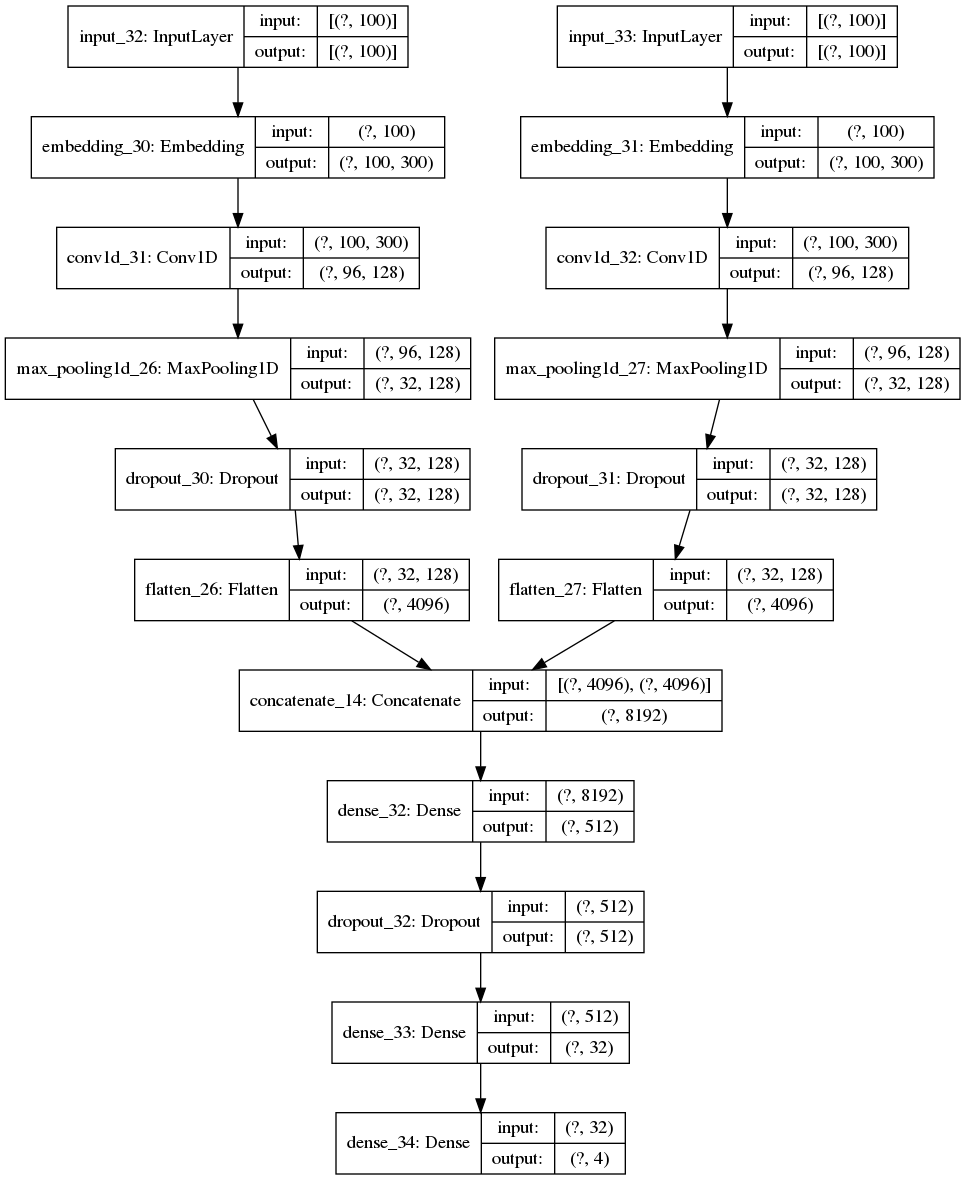

In [65]:
plot_model(classifier, show_shapes=True)

In [66]:
history = classifier.fit([x_train_padded, x_train_padded], 
                         y_train, 
                         epochs=8,
                         batch_size=128,
                         verbose=1,
                         validation_data=([x_val_padded, x_val_padded], y_val))

Epoch 1/8
329/329 [==============================] - 110s 334ms/step - loss: 0.7228 - acc: 0.7806 - val_loss: 0.4461 - val_acc: 0.8532
Epoch 2/8
329/329 [==============================] - 111s 337ms/step - loss: 0.3486 - acc: 0.8833 - val_loss: 0.4001 - val_acc: 0.8616
Epoch 3/8
329/329 [==============================] - 111s 338ms/step - loss: 0.2469 - acc: 0.9211 - val_loss: 0.3903 - val_acc: 0.8698
Epoch 4/8
329/329 [==============================] - 115s 348ms/step - loss: 0.1664 - acc: 0.9495 - val_loss: 0.4242 - val_acc: 0.8677
Epoch 5/8
329/329 [==============================] - 120s 365ms/step - loss: 0.1097 - acc: 0.9698 - val_loss: 0.4660 - val_acc: 0.8735
Epoch 6/8
329/329 [==============================] - 121s 366ms/step - loss: 0.0810 - acc: 0.9780 - val_loss: 0.5108 - val_acc: 0.8632
Epoch 7/8
329/329 [==============================] - 121s 368ms/step - loss: 0.0650 - acc: 0.9837 - val_loss: 0.5513 - val_acc: 0.8669
Epoch 8/8
329/329 [==============================] - 12

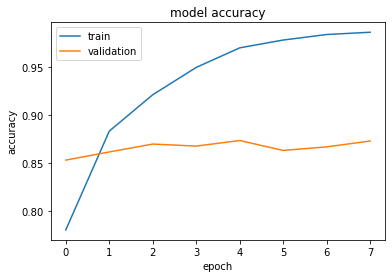

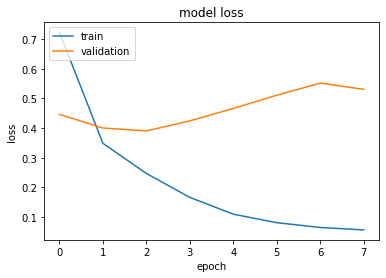

In [67]:
plot_curves(history)

In [68]:
results1 = np.argmax(classifier.predict([x_val_padded, x_val_padded]), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results1)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.873015873015873

Precision:  [0.83123426 0.86683261 0.91727494 0.86268344]
Average Precision:  0.8695063103994282

Recall:  [0.78571429 0.9255814  0.8519774  0.84845361]
Average Recall:  0.8529316726101223

F1-Score:  [0.80783354 0.89524422 0.88342121 0.85550936]
Average F1-Score:  0.8605020788937269


In [70]:
save_model(classifier, "multi-channel-CNN/multi-channel-CNN-valacc-8730")

# LDA Embeddings

In [141]:
def prepare_LDA_input(corpus, LDA_model):
    # Prepare input to LDA model
    corpus = [clean_text(text).split() for text in corpus]
    dict_corpus = Dictionary(corpus)
    dict_corpus.filter_extremes(no_below=5, no_above=0.3, keep_n=None)
    bow_corpus = [dict_corpus.doc2bow(c) for c in corpus]
    
    # Get topic-doc vector
    LDA_input = []
    for doc in bow_corpus:
        LDA_input.append(LDA_model.get_document_topics(doc))
    
    # Add missing probabilities
    for doc in LDA_input:
        index = []
        true_index = set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
        for i in range(len(doc)):
            index.append(doc[i][0])
        new_index = true_index - set(index)
        for j in new_index:
            doc.extend([(j, 0.0)])
        doc.sort() 
        
    # Create input matrix
    LDA_doc = []
    for doc in LDA_input:
        LDA_doc.append(np.asarray([doc[0][1], doc[1][1], doc[2][1], doc[3][1], 
                                   doc[4][1], doc[5][1], doc[6][1], doc[7][1],
                                   doc[8][1], doc[9][1], doc[10][1], doc[11][1]], dtype='float32'))
    LDA_doc = np.array(LDA_doc)
    return LDA_doc

In [142]:
LDA_model = LdaMallet.load("/home/eastwind/word-embeddings/LDA/Normal/TechDofication.LDA.normal.raw.t12")

In [143]:
start = process_time()
X_train_LDA =prepare_LDA_input(training_data.text.values.tolist(), LDA_model)
X_val_LDA =prepare_LDA_input(val_data.text.values.tolist(), LDA_model)
end = process_time()
print("Total time taken: ", end-start)
print(X_train_LDA.shape)
print(X_val_LDA.shape)

Total time taken:  17.191200720999404
(41997, 12)
(3780, 12)


In [144]:
input_len2 = X_train_LDA.shape[1]

# Domain Specific + LDA Multi-channel CNN Architecture

In [145]:
# Input 1(Domain Specific Fasttext Embeddings):
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim1, output_dim=embedding_dim1, weights=[embedding_matrix1], trainable=False)(Input1)
#Conv1 = Conv1D(filters=128, kernel_size=5, activation='relu')(Embedding_layer1)
#MaxPooling1 = MaxPooling1D(pool_size=3)(Conv1)
#Dropout1 = Dropout(0.2)(MaxPooling1)
LSTM1 = Bidirectional(LSTM(64, dropout=0.3, return_sequences=True))(Embedding_layer1)
Dense0 = Dense(32, activation='relu')(LSTM1)
Flatten1 = Flatten()(Dense0)
Dense1 = Dense(512, activation='relu')(Flatten1)
Dropout2 = Dropout(0.3)(Dense1)
Dense2 = Dense(32, activation='relu', kernel_regularizer=l2(0.015))(Dropout2)

# Input 2 (LDA doc embedding):
Input3 = Input(shape=(input_len2,))
Dense3 = Dense(4, activation='relu')(Input3)
Dropout_out = Dropout(0.1)(Dense3)
Merged = concatenate([Dense2, Dropout_out])
output = Dense(4, activation='softmax')(Merged)

classifier2 = Model(inputs=[Input1, Input3], outputs=output)
classifier2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
classifier2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 100, 300)     15772800    input_14[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 100, 128)     186880      embedding_7[0][0]                
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 100, 32)      4128        bidirectional_2[0][0]            
____________________________________________________________________________________________

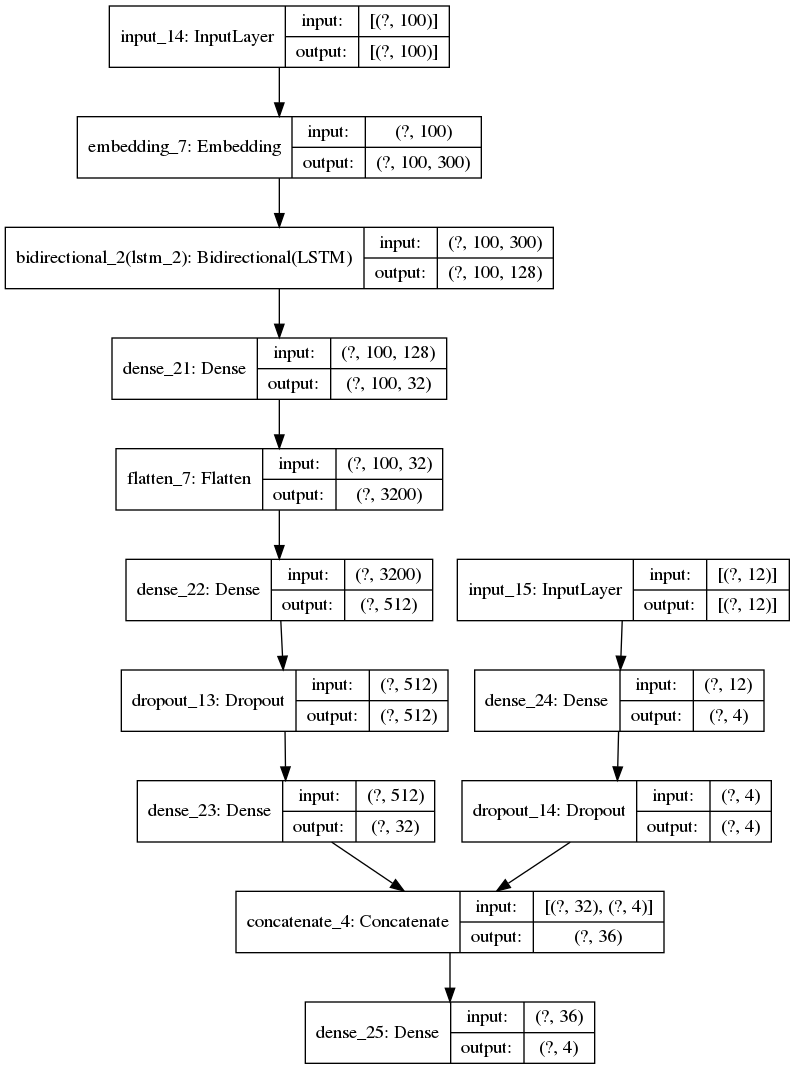

In [146]:
plot_model(classifier2, show_shapes=True, to_file='multichannel.png')

In [147]:
history2 = classifier2.fit([x_train_padded, X_train_LDA], 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            verbose=1,
                            validation_data=([x_val_padded, X_val_LDA], y_val))

Epoch 1/5
329/329 [==============================] - 160s 487ms/step - loss: 0.6743 - acc: 0.7987 - val_loss: 0.4258 - val_acc: 0.8622
Epoch 2/5
329/329 [==============================] - 127s 385ms/step - loss: 0.4127 - acc: 0.8566 - val_loss: 0.3706 - val_acc: 0.8709
Epoch 3/5
329/329 [==============================] - 114s 348ms/step - loss: 0.3720 - acc: 0.8690 - val_loss: 0.3574 - val_acc: 0.8788
Epoch 4/5
329/329 [==============================] - 125s 379ms/step - loss: 0.3426 - acc: 0.8796 - val_loss: 0.3539 - val_acc: 0.8831
Epoch 5/5
329/329 [==============================] - 130s 395ms/step - loss: 0.3219 - acc: 0.8875 - val_loss: 0.3589 - val_acc: 0.8717


In [ ]:
history2 = classifier2.fit([x_train_padded, X_train_LDA], 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            verbose=1,
                            validation_data=([x_val_padded, X_val_LDA], y_val))

Epoch 1/5
329/329 [==============================] - 137s 415ms/step - loss: 0.2181 - acc: 0.9234 - val_loss: 0.3473 - val_acc: 0.8847
Epoch 2/5
329/329 [==============================] - 117s 357ms/step - loss: 0.2065 - acc: 0.9292 - val_loss: 0.3457 - val_acc: 0.8884
Epoch 3/5
329/329 [==============================] - 120s 363ms/step - loss: 0.1911 - acc: 0.9348 - val_loss: 0.3451 - val_acc: 0.8873
Epoch 4/5
329/329 [==============================] - 135s 411ms/step - loss: 0.1854 - acc: 0.9374 - val_loss: 0.3526 - val_acc: 0.8841
Epoch 5/5
329/329 [==============================] - ETA: 0s - loss: 0.1697 - acc: 0.9426

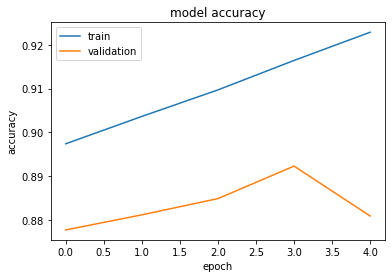

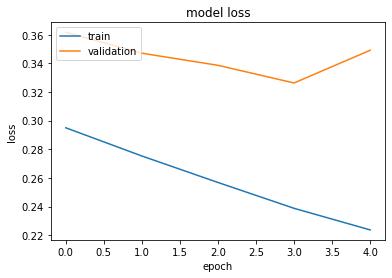

In [151]:
plot_curves(history2)

In [152]:
results2 = np.argmax(classifier2.predict([x_val_padded, X_val_LDA]), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8809523809523809

Precision:  [0.79147982 0.89736842 0.91415313 0.86659664]
Average Precision:  0.8673995031466191

Recall:  [0.84047619 0.90631229 0.89039548 0.85051546]
Average Recall:  0.8719248567446273

F1-Score:  [0.81524249 0.90181818 0.90211792 0.85848075]
Average F1-Score:  0.8694148354230589


In [118]:
results2 = np.argmax(classifier2.predict([x_val_padded, X_val_LDA]), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8835978835978836

Precision:  [0.8707124  0.87042777 0.89597315 0.90044743]
Average Precision:  0.8843901892611075

Recall:  [0.78571429 0.93289037 0.90508475 0.82989691]
Average Recall:  0.8633965760354995

F1-Score:  [0.82603254 0.90057729 0.9005059  0.86373391]
Average F1-Score:  0.8727124103960283


In [120]:
save_model(classifier2, "multi-channel-BiLSTM-LDA4-valacc-8835")

In [1]:
import re